<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Iterators - Loading data
In this tutorial, we focus on how to feed data into a training or inference program.
Most training and inference modules in MXNet accept data iterators,
which simplifies this procedure, especially when reading large datasets.
Here we discuss the API conventions and several provided iterators.

## Prerequisites

To complete this tutorial, we need:  

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/install/index.html).  

- [OpenCV Python library](http://opencv.org/opencv-3-2.html),  [Python Requests](http://docs.python-requests.org/en/master/), [Matplotlib](https://matplotlib.org/) and [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install opencv-python requests matplotlib jupyter
```

## MXNet Data Iterator

Data Iterators in *MXNet* are similar to Python iterator objects.
In Python, the function `iter` allows fetching items sequentially by calling  `next()` on
 iterable objects such as a Python `list`.
Iterators provide an abstract interface for traversing various types of iterable collections
 without needing to expose details about the underlying data source.

In MXNet, data iterators return a batch of data as `DataBatch` on each call to `next`.
A `DataBatch` often contains *n* training examples and their corresponding labels. Here *n* is the `batch_size` of the iterator. At the end of the data stream when there is no more data to read, the iterator raises ``StopIteration`` exception like Python `iter`. 
The structure of `DataBatch` is defined [here](http://mxnet.io/api/python/io/io.html#mxnet.io.DataBatch).

Information such as name, shape, type and layout on each training example and their corresponding label can be provided as `DataDesc` data descriptor objects via the `provide_data` and `provide_label` properties in `DataBatch`.
The structure of `DataDesc` is defined [here](http://mxnet.io/api/python/io/io.html#mxnet.io.DataDesc).

All IO in MXNet is handled via `mx.io.DataIter` and its subclasses. In this tutorial, we'll discuss a few commonly used iterators provided by MXNet.

Before diving into the details let's setup the environment by importing some required packages:

In [1]:
import mxnet as mx
%matplotlib inline
import os
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Reading data in memory
When data is stored in memory, backed by either an `NDArray` or ``numpy`` `ndarray`,
we can use the [__`NDArrayIter`__](http://mxnet.io/api/python/io/io.html#mxnet.io.NDArrayIter) to read data as below:

In [ ]:
import numpy as np

# fix the seed
np.random.seed(42)
mx.random.seed(42)

data = np.random.rand(100,3)
label = np.random.randint(0, 10, (100,))
data_iter = mx.io.NDArrayIter(data=data, label=label, batch_size=30)
for batch in data_iter:
    print([batch.data, batch.label, batch.pad])

## Reading data from CSV files
MXNet provides [`CSVIter`](http://mxnet.io/api/python/io/io.html#mxnet.io.CSVIter)
to read from CSV files and can be used as below:

In [ ]:
#lets save `data` into a csv file first and try reading it back
np.savetxt('data.csv', data, delimiter=',')
data_iter = mx.io.CSVIter(data_csv='data.csv', data_shape=(3,), batch_size=30)
for batch in data_iter:
    print([batch.data, batch.pad])

## Custom Iterator
When the built-in iterators do not suit your application needs,
you can create your own custom data iterator.

An iterator in _MXNet_ should
1. Implement `next()` in ``Python2`` or `__next()__` in ``Python3``,
   returning a `DataBatch` or raising a `StopIteration` exception if at the end of the data stream.
2. Implement the `reset()` method to restart reading from the beginning.
3. Have a `provide_data` attribute, consisting of a list of `DataDesc` objects that store the name, shape, type and layout information of the data (more info [here](http://mxnet.io/api/python/io/io.html#mxnet.io.DataBatch)).
4. Have a `provide_label` attribute consisting of a list of `DataDesc` objects that store the name, shape, type and layout information of the label.

When creating a new iterator, you can either start from scratch and define an iterator or reuse one of the existing iterators.
For example, in the image captioning application, the input example is an image while the label is a sentence.
Thus we can create a new iterator by:
- creating a `image_iter` by using `ImageRecordIter` which provides multithreaded pre-fetch and augmentation.
- creating a `caption_iter` by using `NDArrayIter` or the bucketing iterator provided in the *rnn* package.
- `next()` returns the combined result of `image_iter.next()` and `caption_iter.next()`

The example below shows how to create a Simple iterator.

In [ ]:
class SimpleIter(mx.io.DataIter):
    def __init__(self, data_names, data_shapes, data_gen,
                 label_names, label_shapes, label_gen, num_batches=10):
        self._provide_data = list(zip(data_names, data_shapes))
        self._provide_label = list(zip(label_names, label_shapes))
        self.num_batches = num_batches
        self.data_gen = data_gen
        self.label_gen = label_gen
        self.cur_batch = 0

    def __iter__(self):
        return self

    def reset(self):
        self.cur_batch = 0

    def __next__(self):
        return self.next()

    @property
    def provide_data(self):
        return self._provide_data

    @property
    def provide_label(self):
        return self._provide_label

    def next(self):
        if self.cur_batch < self.num_batches:
            self.cur_batch += 1
            data = [mx.nd.array(g(d[1])) for d,g in zip(self._provide_data, self.data_gen)]
            label = [mx.nd.array(g(d[1])) for d,g in zip(self._provide_label, self.label_gen)]
            return mx.io.DataBatch(data, label)
        else:
            raise StopIteration

We can use the above defined `SimpleIter` to train a simple MLP program below:

In [ ]:
import mxnet as mx
num_classes = 10
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=64)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=num_classes)
net = mx.sym.SoftmaxOutput(data=net, name='softmax')
print(net.list_arguments())
print(net.list_outputs())

Here, there are four variables that are learnable parameters:
the *weights* and *biases* of FullyConnected layers *fc1* and *fc2*,
two variables for input data: *data* for the training examples
and *softmax_label* contains the respective labels and the *softmax_output*.

The *data* variables are called free variables in MXNet's Symbol API.
To execute a Symbol, they need to be bound with data.
[Click here learn more about Symbol](http://mxnet.io/tutorials/basic/symbol.html).

We use the data iterator to feed examples to a neural network via MXNet's `module` API.
[Click here to learn more about Module](http://mxnet.io/tutorials/basic/module.html).

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)

n = 32
data_iter = SimpleIter(['data'], [(n, 100)],
                  [lambda s: np.random.uniform(-1, 1, s)],
                  ['softmax_label'], [(n,)],
                  [lambda s: np.random.randint(0, num_classes, s)])

mod = mx.mod.Module(symbol=net)
mod.fit(data_iter, num_epoch=5)

A note on python 3 usage: Lot of the methods in mxnet use string for python2 and bytes for python3. 
In order to keep this tutorial readable, we are going to define a utility function that converts
string to bytes in python 3 environment

In [ ]:
def str_or_bytes(str):
    """
    A utility function for this tutorial that helps us convert string 
    to bytes if we are using python3.

    Parameters
    ----------
    str : string

    Returns
    -------
    string (python2) or bytes (python3)
    """
    if sys.version_info[0] < 3:
        return str
    else:
        return bytes(str, 'utf-8')

## Record IO
Record IO is a file format used by MXNet for data IO.
It compactly packs the data for efficient read and writes from distributed file system like Hadoop HDFS and AWS S3.
You can learn more about the design of `RecordIO` [here](http://mxnet.io/architecture/note_data_loading.html).

MXNet provides [__`MXRecordIO`__](http://mxnet.io/api/python/io/io.html#mxnet.recordio.MXRecordIO)
and [__`MXIndexedRecordIO`__](http://mxnet.io/api/python/io/io.html#mxnet.recordio.MXIndexedRecordIO)
for sequential access of data and random access of the data.

### MXRecordIO
First, let's look at an example on how to read and write sequentially
using `MXRecordIO`. The files are named with a `.rec` extension.

In [ ]:
record = mx.recordio.MXRecordIO('tmp.rec', 'w')
for i in range(5):
    record.write(str_or_bytes('record_%d'%i))

record.close()

We can read the data back by opening the file with an option `r` as below:

In [ ]:
record = mx.recordio.MXRecordIO('tmp.rec', 'r')
while True:
    item = record.read()
    if not item:
        break
    print (item)
record.close()

### MXIndexedRecordIO
`MXIndexedRecordIO` supports random or indexed access to the data.
We will create an indexed record file and a corresponding index file as below:

In [ ]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'w')
for i in range(5):
    record.write_idx(i, str_or_bytes('record_%d'%i))

record.close()

Now, we can access the individual records using the keys

In [ ]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'r')
record.read_idx(3)

You can also list all the keys in the file.

In [ ]:
record.keys

### Packing and Unpacking data

Each record in a .rec file can contain arbitrary binary data. However, most deep learning tasks require data to be input in label/data format.
The `mx.recordio` package provides a few utility functions for such operations, namely: `pack`, `unpack`, `pack_img`, and `unpack_img`.

#### Packing/Unpacking Binary Data

[__`pack`__](http://mxnet.io/api/python/io/io.html#mxnet.recordio.pack) and [__`unpack`__](http://mxnet.io/api/python/io/io.html#mxnet.recordio.unpack) are used for storing float (or 1d array of float) label and binary data. The data is packed along with a header. The header structure is defined [here](http://mxnet.io/api/python/io/io.html#mxnet.recordio.IRHeader).

In [ ]:
# pack
data = 'data'
label1 = 1.0
header1 = mx.recordio.IRHeader(flag=0, label=label1, id=1, id2=0)
s1 = mx.recordio.pack(header1, str_or_bytes(data))

label2 = [1.0, 2.0, 3.0]
header2 = mx.recordio.IRHeader(flag=3, label=label2, id=2, id2=0)
s2 = mx.recordio.pack(header2, str_or_bytes(data))

In [ ]:
# unpack
print(mx.recordio.unpack(s1))
print(mx.recordio.unpack(s2))

#### Packing/Unpacking Image Data

MXNet provides [__`pack_img`__](http://mxnet.io/api/python/io/io.html#mxnet.recordio.pack_img) and [__`unpack_img`__](http://mxnet.io/api/python/io/io.html#mxnet.recordio.unpack_img) to pack/unpack image data.
Records packed by `pack_img` can be loaded by `mx.io.ImageRecordIter`.

In [ ]:
data = np.ones((3,3,1), dtype=np.uint8)
label = 1.0
header = mx.recordio.IRHeader(flag=0, label=label, id=0, id2=0)
s = mx.recordio.pack_img(header, data, quality=100, img_fmt='.jpg')

In [ ]:
# unpack_img
print(mx.recordio.unpack_img(s))

#### Using tools/im2rec.py
You can also convert raw images into *RecordIO* format using the [__im2rec.py__](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) utility script that is provided in the MXNet [src/tools](https://github.com/dmlc/mxnet/tree/master/tools) folder.
An example of how to use the script for converting to *RecordIO* format is shown in the `Image IO` section below.

* Note that there is a C++ API implementation of [im2rec](https://github.com/dmlc/mxnet/blob/master/tools/im2rec.cc), please refer to [RecordIO FAQ](https://mxnet.incubator.apache.org/faq/recordio.html) for more information.

## Image IO

In this section, we will learn how to preprocess and load image data in MXNet.

There are 4 ways of loading image data in MXNet.
   1. Using [__mx.image.imdecode__](http://mxnet.io/api/python/io/io.html#mxnet.image.imdecode) to load raw image files.
   2. Using [__`mx.img.ImageIter`__](http://mxnet.io/api/python/io/io.html#mxnet.image.ImageIter) implemented in Python which is very flexible to customization. It can read from .rec(`RecordIO`) files and raw image files.
   3. Using [__`mx.io.ImageRecordIter`__](http://mxnet.io/api/python/io/io.html#mxnet.io.ImageRecordIter) implemented on the MXNet backend in C++. This is less flexible to customization but provides various language bindings.
   4. Creating a Custom iterator inheriting `mx.io.DataIter`


### Preprocessing Images
Images can be preprocessed in different ways. We list some of them below:
- Using `mx.io.ImageRecordIter` which is fast but not very flexible. It is great for simple tasks like image recognition but won't work for more complex tasks like detection and segmentation.
- Using `mx.recordio.unpack_img` (or `cv2.imread`, `skimage`, etc) + `numpy` is flexible but slow due to Python Global Interpreter Lock (GIL).
- Using MXNet provided `mx.image` package. It stores images in [__`NDArray`__](http://mxnet.io/tutorials/basic/ndarray.html) format and leverages MXNet's [dependency engine](http://mxnet.io/architecture/note_engine.html) to automatically parallelize processing and circumvent GIL.

Below, we demonstrate some of the frequently used preprocessing routines provided by the `mx.image` package.

Let's download sample images that we can work with.

In [2]:
fname = mx.test_utils.download(url='http://data.mxnet.io/data/test_images.tar.gz', dirname='data', overwrite=False)
tar = tarfile.open(fname)
tar.extractall(path=os.path.join('.','data'))
tar.close()

#### Loading raw images
`mx.image.imdecode` lets us load the images. `imdecode` provides a similar interface to ``OpenCV``.  

**Note:** You will still need ``OpenCV``(not the CV2 Python library) installed to use `mx.image.imdecode`.

In [19]:
!pip install opencv-python

    100% |████████████████████████████████| 39.7MB 777kB/s ta 0:00:011    69% |██████████████████████▍         | 27.8MB 7.6MB/s eta 0:00:02    89% |████████████████████████████▊   | 35.7MB 8.1MB/s eta 0:00:01
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


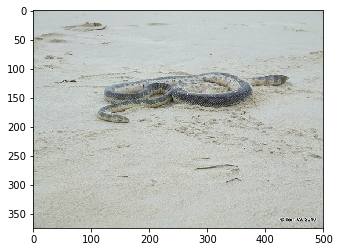

In [20]:
img = mx.image.imdecode(open(os.path.join('data','test_images','ILSVRC2012_val_00000001.JPEG'), 'rb').read())
plt.imshow(img.asnumpy()); plt.show()

#### Image Transformations

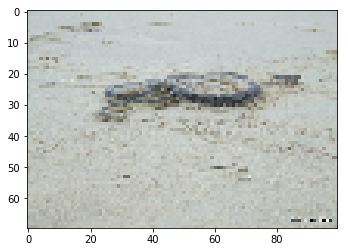

In [21]:
# resize to w x h
tmp = mx.image.imresize(img, 100, 70)
plt.imshow(tmp.asnumpy()); plt.show()

(73, 142, 150, 200)


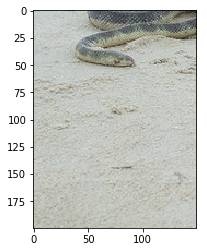

In [22]:
# crop a random w x h region from image
tmp, coord = mx.image.random_crop(img, (150, 200))
print(coord)
plt.imshow(tmp.asnumpy()); plt.show()

### Loading Data using Image Iterators

Before we see how to read data using the two built-in Image iterators,
 lets get a sample __Caltech 101__ dataset
 that contains 101 classes of objects and converts them into record io format.
Download and unzip

In [23]:
fname = mx.test_utils.download(url='http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz', dirname='data', overwrite=False)
tar = tarfile.open(fname)
tar.extractall(path=os.path.join('.','data'))
tar.close()

Let's take a look at the data. As you can see, under the root folder (./data/101_ObjectCategories) every category has a subfolder(./data/101_ObjectCategories/yin_yang).

Now let's convert them into record io format using the `im2rec.py` utility script.
First, we need to make a list that contains all the image files and their categories:

In [4]:
im2rec_path = mx.test_utils.get_im2rec_path()
data_path = os.path.join('data','101_ObjectCategories')
prefix_path = os.path.join('data','caltech')
print(im2rec_path)
# print(prefix_path)
with open(os.devnull, 'wb') as devnull:
    subprocess.check_call(['python', im2rec_path, '--list', '--recursive', '--test-ratio=0.2', prefix_path, data_path],
                          stdout=devnull)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mxnet/tools/im2rec.py


CalledProcessError: Command '['python', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mxnet/tools/im2rec.py', '--list', '--recursive', '--test-ratio=0.2', 'data/caltech', 'data/101_ObjectCategories']' returned non-zero exit status 1.

The resulting list file (./data/caltech_train.lst) is in the format `index\t(one or more label)\tpath`. In this case, there is only one label for each image but you can modify the list to add in more for multi-label training.

Then we can use this list to create our record io file:

In [16]:
with open(os.devnull, 'wb') as devnull:
    subprocess.check_call(['python', im2rec_path, '--num-thread=4', '--pass-through', '--test-ratio=0.2', prefix_path, data_path],
                          stdout=devnull)

CalledProcessError: Command '['python', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mxnet/tools/im2rec.py', '--num-thread=4', '--pass-through', '--test-ratio=0.2', 'data/caltech', 'data/101_ObjectCategories']' returned non-zero exit status 1.

The record io files are now saved at here (./data)

#### Using ImageRecordIter
[__`ImageRecordIter`__](http://mxnet.io/api/python/io/io.html#mxnet.io.ImageRecordIter) can be used for loading image data saved in record io format. To use ImageRecordIter, simply create an instance by loading your record file:

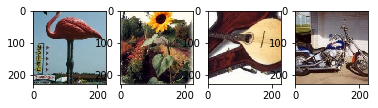

In [5]:
data_iter = mx.io.ImageRecordIter(
    path_imgrec=os.path.join('.','data','caltech.rec'),
    data_shape=(3, 227, 227), # output data shape. An 227x227 region will be cropped from the original image.
    batch_size=4, # number of samples per batch
    resize=256 # resize the shorter edge to 256 before cropping
    # ... you can add more augmentation options as defined in ImageRecordIter.
    )
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

#### Using ImageIter
[__ImageIter__](http://mxnet.io/api/python/io/io.html#mxnet.io.ImageIter) is a flexible interface that supports loading of images in both RecordIO and Raw format.

In [ ]:
data_iter = mx.image.ImageIter(batch_size=4, data_shape=(3, 227, 227),
                              path_imgrec=os.path.join('.','data','caltech.rec'),
                              path_imgidx=os.path.join('.','data','caltech.idx') )
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()


<!-- INSERT SOURCE DOWNLOAD BUTTONS -->

